<h1 align='center'> Simulation of a FACET-II type plasma wakefield accelerator</h1>
<center>
Stephen D. Webb <br>
RadiaSoft, LLC <br>
swebb@radiasoft.net</center>

Developed for a project supported by the United States Department of Energy, Office of Science, Office of High Energy Physics under contract number DE-SC0018718.

***
## Introduction

This notebook is meant to model a beam-driven plasma wakefield accelerator using nominal FACET-II parameters with an unchanging drive and witness bunch, in an effort to compute the $m=0$ wake fields from the drive bunch using our technique developed and demonstrated with the hollow channel.


***

In [34]:
## Imports

# standard python libraries
import numpy as np
from scipy import constants

import shutil, os

%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc

import h5py as hdf5

# OpenPMD for looking at the file data
from opmd_viewer import OpenPMDTimeSeries

# Imports for the simulations, and setting up the plots
from fbpic.main import Simulation
from fbpic.openpmd_diag import FieldDiagnostic, ParticleDiagnostic, ParticleChargeDensityDiagnostic, \
     set_periodic_checkpoint, restart_from_checkpoint
from fbpic.lpa_utils.bunch import add_elec_bunch_gaussian

# set the colormap and centre the colorbar

import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
## Simulation Parameters

In this section, we develop a simulation of the hollow channel. The hollow channel refers to the fact that a drive and witness bunch travel through a hollow ring of plasma -- this set up is akin to having an extremely small beam pipe. For the FBPIC simulation, this requires creating a ring of quiescent electron plasma, and a drive and witness beam initiated with self-consistent fields. We will neglect the ion motion in the plasma channel for this simulation.

The simulation uses a moving window, beginning with the drive and witness bunch outside the hollow plasma channel, then passing through, with the simulation running until the fields reach an approximate steady state. We will then use those fields to compute the wake fields and impedances, and compare to the theoretical results in [ref. 1](#References).

The hollow plasma channel has a density $n_e$ and a radius $b$, and the local plasma frequency is given by $\omega_p = \sqrt{\frac{4 \pi n_e e^2}{m_e}}$ for the electron charge $e$ and mass $m_e$. The plasma wavenumber is $k_p = \omega_p / c$. Because PIC algorithms do not like hard edges in charge density, we will use a linear ramp on the density of the plasma hollow channel, with a slope $k_{ramp}$ specified below.

The baseline parameters for our studies will be the nominal design FACET-II parameters described in [ref. 3](#References), and a plasma channel radius of thrice the beam $\sigma_r$.

In [35]:
## Domain physical parameters



## Beam parameters

# Drive bunch is gaussian

# turn the drive beam on and off, as required.
use_drive_bunch = True

drive_sigma_r = 3.65e-6  # meters
drive_sigma_z = 12.77e-6  # meters
drive_Q = 1.e10*(-1.*constants.elementary_charge)   # Coulombs
drive_N_macro = 1000
drive_gamma = 10.e3

# Witness bunch, also gaussian

# turn the witness beam on and off, as required.
use_witness_bunch = False

witness_sigma_r = 3.65e-6 #meters
witness_sigma_z = 6.38e-6  # meters
witness_Q = 4.3e9*(-1.*constants.elementary_charge)   # Coulombs
witness_N_macro = 1000
witness_gamma = 10.e4

trailing_distance = 150.e-6 # meters


## Plasma channel parameters

n_plasma = 4.e16        # cm^-3

# convert to per cubic meter
n_plasma *= 100**3

# derived plasma quantities
omega_p = np.sqrt(n_plasma*constants.elementary_charge**2/(constants.m_e*constants.epsilon_0))
k_p = omega_p/constants.c

lambda_p = 2.*np.pi/k_p

## Domain parameters

# Domain size, include the whole thing and some trailing distance
domain_length = 1.7*lambda_p  # meters
domain_radius = 1.7*lambda_p  # meters

# Grid size, resolve the drive bunch
Delta_z = 0.1*min([drive_sigma_z, lambda_p, witness_sigma_z])  # meters
Delta_r = 0.1*min([drive_sigma_r, lambda_p, witness_sigma_r])  # meters

# Derived quantities
Nz = int(np.rint(domain_length/Delta_z))
Nr = int(np.rint(domain_radius/Delta_r))

dt = (np.sqrt(Delta_z**2 + Delta_r**2)/constants.c)        # sec, small fudge factor 
                                                                # to prevent particles from 
                                                                # covering a full cell per time step
        
# Moving window
window_v = constants.c

# start the ramp after the drive bunch has existed a while

ramp_start = domain_length
ramp_length = 5.*drive_sigma_z


# create the density function for the plasma, which is uniform
def dens_func( z, r ) :
    """Returns relative density at position z and r"""
    # Allocate relative density
    n = np.ones_like(z)
    # Make linear ramp
    n = np.where( z < ramp_start + ramp_length, (z-ramp_start)/ramp_length, n )
    # Supress density before the ramp
    n = np.where( z < ramp_start, 0., n )
    return(n)

# We want to run the simulation just long enough for the fields to form behind the drive bunch, 
# so we will simulate for twenty bunch sigmas

sim_length = (ramp_start + ramp_length + 10.*lambda_p)/constants.c

Nsteps = int(sim_length/dt)-int(sim_length/dt)%100 + 1

# Use only the primary azimuthal mode
Nm = 1

# Define the diagnostics
write_fields = True
write_particles = True
dump_period = 30 #Nsteps-1


***
## The Simulation

Here we run the actual simulation of the beams traveling through the hollow channel.

***

In [36]:
# remove old data
if os.path.exists('./diags/hdf5'):
    shutil.rmtree('./diags/hdf5')

# Create the simulation
sim = Simulation(Nz, domain_length, Nr, domain_radius, Nm, dt, boundaries='open')
# micromanage the particle species
sim.ptcl = []

# add the gaussian drive bunch
if use_drive_bunch:
    add_elec_bunch_gaussian( sim, 
                            sig_r = drive_sigma_r, 
                            sig_z = drive_sigma_z, 
                            n_emit=0., 
                            gamma0=drive_gamma, 
                            sig_gamma=1.,
                            Q=-1.*drive_Q, 
                            N=drive_N_macro, 
                            tf=0.0, 
                            zf=.75*domain_length, boost=None)
    
    if write_particles:
        sim.diags.append( ParticleChargeDensityDiagnostic(dump_period, sim,
                    species={'driver_bunch': sim.ptcl[0]}) )
if use_witness_bunch:
    add_elec_bunch_gaussian( sim, 
                            sig_r = witness_sigma_r, 
                            sig_z = witness_sigma_z, 
                            n_emit=0., 
                            gamma0=drive_gamma, 
                            sig_gamma=1.,
                            Q=-1.*witness_Q, 
                            N=witness_N_macro, 
                            tf=0.0, 
                            zf=.75*domain_length - trailing_distance, boost=None)

# add the hollow channel electrons
plasma_electrons = sim.add_new_species(q = -1.*constants.elementary_charge,
                                 m = constants.electron_mass,
                                 dens_func = dens_func, 
                                 n = n_plasma, p_nz = 1, p_nr = 1, p_nt = 1)

if write_particles:
    sim.diags.append( ParticleDiagnostic(dump_period,
                    {'electrons': sim.ptcl[-1]}, sim.comm ) )

plasma_ions = sim.add_new_species(q = constants.elementary_charge,
                                 m = constants.proton_mass,
                                 dens_func = dens_func, 
                                 n = n_plasma, p_nz = 1, p_nr = 1, p_nt = 1)

# Set the moving window
sim.set_moving_window(v = window_v)

# Add diagnostics
if write_fields:
    sim.diags.append( FieldDiagnostic(dump_period, sim.fld, sim.comm ) )
    
# remove old data
# run the simulation
sim.step(Nsteps)


FBPIC (0.11.0)

Running on CPU (8 threads per process) 

Calculating initial space charge field...
Done.

|█                                  | 736/23101, 3:30:10 left, 539 ms/stepp

KeyboardInterrupt: 

Now we try to make a video of the plasma bubble from the data to see if it's evolving

In [25]:
# import the list of data files
files_list = os.listdir('./diags/hdf5')
dir_name = './diags/hdf5'
step_list = []
for file_name in files_list:
    step_num = int(file_name[-8:-3])
    step_list.append(step_num)

ts = OpenPMDTimeSeries(dir_name)

In [26]:
# create a function that computes F_r and F_z from the fields in a given file
def force_vector(dir_name, step_num):
    """ Computes the radial and longitudinal force/charge from a file's field data
    
    Arguments
    file_name: string that gives the file to open
    
    Returns
    F_r: the radial force/charge
    F_z: the longitudinal force/charge
    """

    ts = OpenPMDTimeSeries(dir_name)
    Ez_field, meta = ts.get_field(field='E', coord='z', iteration=step_num)
    Er_field, meta = ts.get_field(field='E', coord='r', iteration=step_num)
    Bt_field, meta = ts.get_field(field='B', coord='t', iteration=step_num)

    rgrid = meta.r
    zgrid = meta.z
    
    F_r = Er_field - constants.speed_of_light*Bt_field
    F_z = Ez_field
    
    return F_r, F_z, rgrid, zgrid

In [27]:
# A function to compute the curl of the force, on a discrete mesh, at the cell midpoints
def curl(F_r, F_z, rs, zs):
    """ Compute the curl of the force, which is zero in the Panofsky-Wenzel limit
    Arguments:
    F_r: vector for the radial force
    F_z: vector for the longitudinal force
    rs : vector of the radial grid points
    zs : vector of the longitudinal grid points
    
    Returns:
    curl_F : curl of the force
    curl_rs: radial coordinates of the curl vector
    curl_zs: longitudinal coordinates of the curl vector
    """
    
    # finite difference in case of variable grid size

    del_r = rs[1:-1] - rs[0:-2]
    del_z = zs[1:-1] - zs[0:-2]
    
    # To co-locate the forces, linearly interpolate to the mid-points on the off-axes
    F_r = (F_r[0:-2,:]+F_r[1:-1,:])/2.
    F_z = (F_z[:,0:-2]+F_z[0,1:-1])/2.
    
    # finite difference the force for the derivatives
    # dFr_dz in this form lives at the midpoints of the z-axis cell edges
    dFr_dz = (F_r[:,1:-1] - F_r[:,0:-2])/del_z[0]
    # dFz_dr in this form lives at the midpoints of the r-axis cell edges
    dFz_dr = (F_z[1:-1,:] - F_z[0:-2,:])/del_r[0]
    
    curl_F =  (dFr_dz - dFz_dr)
    curl_rs = (rs[1:-1] + rs[0:-2])/2.
    curl_zs = (zs[1:-1] + zs[0:-2])/2.
    
    return curl_F, curl_rs, curl_zs

In [28]:
# Pre-process the ranges of data for the color bars

fravg = 0.
frmin = 0.
frmax = 0.

fzavg = 0.
fzmin = 0.
fzmax = 0.

curlavg = 0.
curlmin = 0.
curlmax = 0.
        
for steps in step_list:
    Fr, Fz, rgrid, zgrid = force_vector(dir_name, steps)

    fmin = np.amin(Fr*1.e-9)
    if fmin < frmin:
        frmin = fmin
    fmax = np.amax(Fr*1.e-9)
    if fmax > frmax:
        frmax = fmax
    
    fmin = np.amin(Fz*1.e-9)
    if fmin < fzmin:
        fzmin = fmin
    fmax = np.amax(Fz*1.e-9)
    if fmax > fzmax:
        fzmax = fmax
        
    curl_F, rs, zs = curl(Fr, Fz, rgrid, zgrid)

    cmin = np.amin(curl_F*1.e-9)
    if cmin < curlmin:
        curlmin = cmin
    cmax = np.amax(Fz*1.e-9)
    if cmax > curlmax:
        curlmax = cmax

<IPython.core.display.Javascript object>


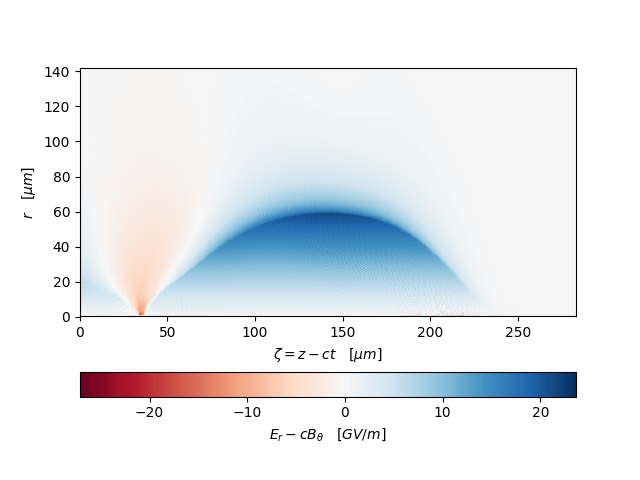

In [29]:
#setup figure
fig = plt.figure()

#set up list of images for animation
ims=[]

plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')

for steps in step_list:
    Fr, Fz, rgrid, zgrid = force_vector(dir_name, steps)
    r_mid = len(rgrid)/2
    
    extent = [(zgrid[0]-constants.speed_of_light*steps*dt)*1.e6,
             (zgrid[-1]-constants.speed_of_light*steps*dt)*1.e6,
             rgrid[r_mid]*1.e6, rgrid[r_mid+r_mid/2]*1.e6]
    
    im = plt.imshow(Fr[r_mid:r_mid+r_mid/2,:]*1.e-9, extent = extent,
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax),
                   animated=True)
        
    ims.append([im])
    
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_r - c B_\theta \quad [GV/m]$')

#run animation
ani = animation.ArtistAnimation(fig,ims, interval=100, blit=True)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('pwfa_Er.mp4', writer=writer)

<IPython.core.display.Javascript object>


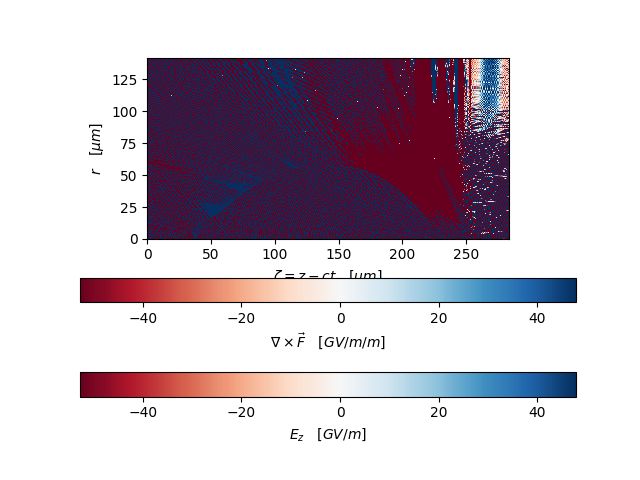

In [30]:
#setup figure
fig = plt.figure()

#set up list of images for animation
ims=[]

plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')

for steps in step_list:
    Fr, Fz, rgrid, zgrid = force_vector(dir_name, steps)
    r_mid = len(rgrid)/2
    
    extent = [(zgrid[0]-constants.speed_of_light*steps*dt)*1.e6,
             (zgrid[-1]-constants.speed_of_light*steps*dt)*1.e6,
             rgrid[r_mid]*1.e6, rgrid[r_mid+r_mid/2]*1.e6]
    
    im = plt.imshow(Fz[r_mid:r_mid+r_mid/2,:]*1.e-9, extent = extent,
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=fzavg,vmin=fzmin, vmax=fzmax),
                   animated=True)
        
    ims.append([im])
    
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_z \quad [GV/m]$')

#run animation
ani = animation.ArtistAnimation(fig,ims, interval=100, blit=True)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('pwfa_Ez.mp4', writer=writer)

<IPython.core.display.Javascript object>


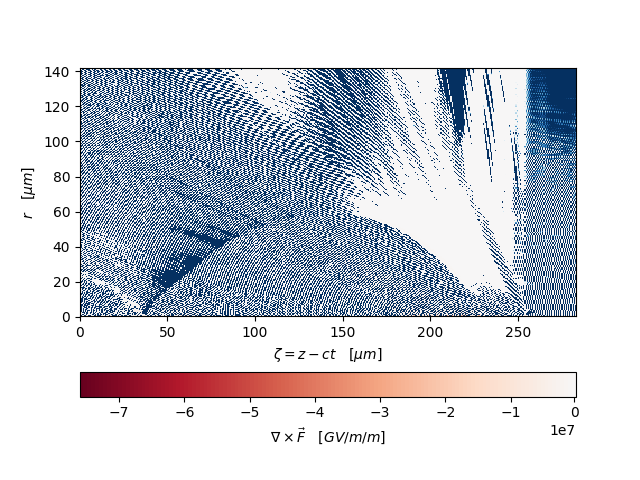

In [33]:
# Look at the evolving curl(F)

#setup figure
fig = plt.figure()

#set up list of images for animation
ims=[]

plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')

for steps in step_list:
    Fr, Fz, rgrid, zgrid = force_vector(dir_name, steps)
    
    curl_F, rs, zs = curl(Fr, Fz, rgrid, zgrid)

    r_mid = len(rgrid)/2
    
    extent = [(zgrid[0]-constants.speed_of_light*steps*dt)*1.e6,
             (zgrid[-1]-constants.speed_of_light*steps*dt)*1.e6,
             rgrid[r_mid]*1.e6, rgrid[r_mid+r_mid/2]*1.e6]
    
    im = plt.imshow(curl_F[r_mid:r_mid+r_mid/2,:]*1.e-9, extent = extent,
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=curlavg,vmin=curlmin, vmax=curlmax),
                   animated=True)
        
    ims.append([im])
    
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$\nabla \times \vec{F} \quad [GV/m/m]$')

#run animation
ani = animation.ArtistAnimation(fig,ims, interval=100, blit=True)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('curl.mp4', writer=writer)

***
## References

> 1. C. B. Schroeder, D. H. Whittum, and J. S. Wurtele, "Multimode Analysis of the Hollow Plasma Channel Wakefield Accelerator", _Phys. Rev. Lett._ __82__, 1177 (1999). [https://doi.org/10.1103/PhysRevLett.82.1177](https://doi.org/10.1103/PhysRevLett.82.1177)

> 2. R. Lehe, M. Kirchen, I. A. Andriyash, B. B. Godfrey, and J.-L. Vay, "A spectral, quasi-cylindrical and dispersion-free Particle-In-Cell algorithm", _Comp. Phys. Comm._ __203__, pp. 66-82 (2016). [https://doi.org/10.1016/j.cpc.2016.02.007](https://doi.org/10.1016/j.cpc.2016.02.007)

> 3. C. Joshi _et al._ "Plasma wakefield acceleration experiments at FACET II", _Plasma Phys. Control. Fusion_ __60__, 3 (2018).

> 4. A. W. Chao, "Physics of Collective Beam Instabilities in High Energy Accelerators", John Wiley & Sons (1993)

> 5. C. A. Lindstrom _et al._ "Measurement of Transverse Wakefields Induced by a Misaligned Positron Bunch in a Hollow Channel Plasma Accelerator", _Phys. Rev. Lett._ __120__, 124802 (2018).